### 3.9. Продвинутая визуализация. Параметр sharey



В этой и предыдущей темах мы строили много графиков — кривые, графики истории изменений, тепловые карты. Такие задачи возникают в работе аналитика очень часто. Чтобы всякий раз не писать новый код, создадим универсальные функции для визуализации удержания, конверсии и ROI, которые позволят за один вызов получить сразу несколько важных графиков на одной сетке.

#### Удержание

Возьмём уже знакомые данные интернет-магазина книг «Читать не вредно» и рассчитаем удержание с разбивкой по устройствам, вызвав функцию `get_retention()`.


In [17]:
import pandas as pd
import seaborn as sns

In [18]:
# функции get_retention(), get_conversion(), get_profiles() из предыдущих уроков

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time



def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(
        0
    )
    
    return profiles  # возвращаем профили с CAC

In [19]:
costs = pd.read_csv('/datasets/ad_costs_new.csv')
# преобразуем данные о времени
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

sessions = pd.read_csv('/datasets/sessions.csv')  # сессии
orders = pd.read_csv('/datasets/book_orders.csv')  # данные о покупках
events = pd.read_csv('/datasets/events.csv')  # данные о событиях

# преобразуем данные о времени
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
events['event_time'] = pd.to_datetime(events['event_time'])

profiles = get_profiles(sessions, orders, events, costs)

profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01,True,0.249238
1,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01,False,0.239416
2,12545358,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01,False,0.000000
3,16165560,2019-05-10 20:29:59,Yandex,PC,United States,2019-05-10,2019-05-01,False,0.239416
4,17733464,2019-05-12 11:08:25,Organic,iPhone,France,2019-05-12,2019-05-01,True,0.000000


In [20]:
from datetime import datetime, timedelta

retention_raw, retention, retention_history = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 7, dimensions=['device']
)

retention

cohort_size    0         1         2         3         4  \
payer device                                                              
False Android        12850  1.0  0.243191  0.143891  0.102101  0.077121   
      Mac            16174  1.0  0.233894  0.146902  0.099172  0.075553   
      PC              6744  1.0  0.235024  0.141311  0.100830  0.080813   
      iPhone         28812  1.0  0.239067  0.142996  0.101902  0.076704   
True  Android         1466  1.0  0.377217  0.284447  0.218281  0.167121   
      Mac             1791  1.0  0.394193  0.296482  0.232272  0.184255   
      PC               752  1.0  0.378989  0.284574  0.207447  0.176862   
      iPhone          3304  1.0  0.375303  0.282385  0.196429  0.184927   

                      5         6  
payer device                       
False Android  0.061012  0.050584  
      Mac      0.062817  0.050390  
      PC       0.064353  0.055160  
      iPhone   0.061329  0.048799  
True  Android  0.156207  0.137108  
      Mac      0.139587  0.144054  
      PC       0.147606  0.130319  
      iPhone   0.165860  0.129843

Напишем функцию `plot_retention()`, которая построит четыре графика:

- кривые удержания для платящих пользователей,
- кривые удержания для неплатящих,
- динамику удержания для платящих пользователей,
- динамику удержания для неплатящих.

Все графики разместим на одной подложке, чтобы легче было оценить всю ситуацию.

#### Кривые удержания

Для начала «научим» функцию строить кривые удержания.

По умолчанию `get_retention()` для расчёта удержания разбивает пользователей на платящих и неплатящих, если в параметре `dimensions` ничего нет. По этому же признаку мы хотим разбить графики, поэтому при отсутствии других признаков для группировки функция `plot_retention()` сломается. 

Избежать этого можно тем же способом, что и при расчёте конверсии и LTV, — добавив «фиктивный» признак `cohort`, который объединяет всех пользователей.

In [21]:
def plot_retention(retention):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке — кривые удержания неплатящих
    ax2 = plt.subplot(2, 2, 2)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    plt.show()

Вызовем новую функцию, передав ей ранее полученную таблицу удержания пользователей магазина «Читать не вредно» с разбивкой по устройствам.

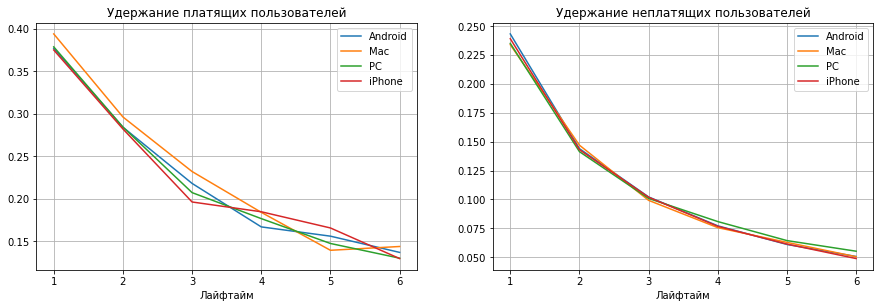

In [23]:
import matplotlib.pyplot as plt

plot_retention(retention)

Функция `plot_retention()` работает как задумано. Правда, сравнить удержание платящих и неплатящих пользователей трудно — из-за разного масштаба графиков по оси Y. Это можно исправить, передав функции `subplot()` параметр `sharey`.

### Параметр `sharey` функции `subplot()`

Параметр `sharey` задаёт график, вертикальную ось которого следует перенять. Параметру передают расположение такого графика, заданное функцией `subplot()`.

<img src="https://pictures.s3.yandex.net/resources/12_code_1620503916.png"> 

В написанной нами функции `plot_retention()` расположение графика удержания платящих пользователей сохранено в переменной `ax1`. Чтобы «поделиться» его осью Y с графиком удержания неплатящих пользователей, передадим `ax1` параметру `sharey`, задавая место для последнего графика в переменной `ax2`.


```python
# сохраняем расположение графика для неплатящих пользователей
# вертикальную ось возьмём из графика для платящих

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
```

Дополним этой строчкой функцию `plot_retention()` и оценим результат.

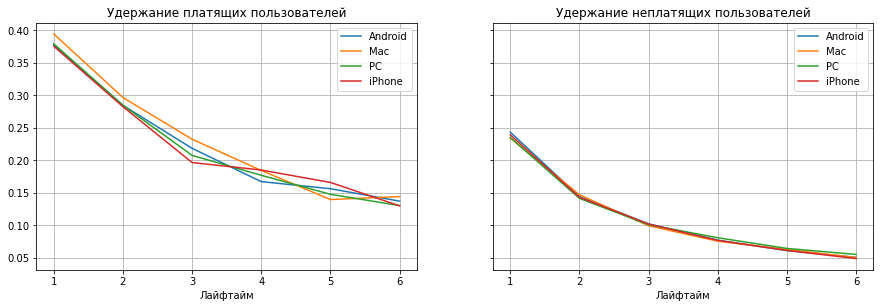

In [24]:
def plot_retention(retention):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    plt.show()

plot_retention(retention)

По графикам с одинаковым масштабом по вертикальной оси легко заметить, что удержание неплатящих пользователей намного ниже, чем удержание платящих.

#### Динамика удержания

Чтобы функция `plot_retention()` могла построить не только кривые удержания, но и графики истории изменений, передадим ей два дополнительных параметра: 

- `retention_history` — таблицу динамики удержания,
- `horizon` — день жизни, по которому хотим изучить динамику удержания.

В тело функции добавим построение графика истории изменений для платящих пользователей — в третьей из четырёх доступных ячеек таблицы графиков.

Графики динамики удержания за определённый день «жизни» строят по сводным таблицам, в которой названия строк — это даты привлечения, названия столбцов — признаки для группировки, а значения — данные удержания за желаемый лайфтайм. 

Признаки для группировки возьмём из индексов таблицы удержания. Для этого создадим генератор списков: получим название каждого столбца в индексе таблицы динамики удержания, если это не дата привлечения из `dt` и не совершение покупки из `payer`.


In [25]:
def plot_retention(retention, retention_history, horizon):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.show()

Построим график истории изменений удержания на конец первой недели, передав функции `plot_retention()` таблицу динамики удержания `retention_history` и день «жизни» для изучения — `7`.

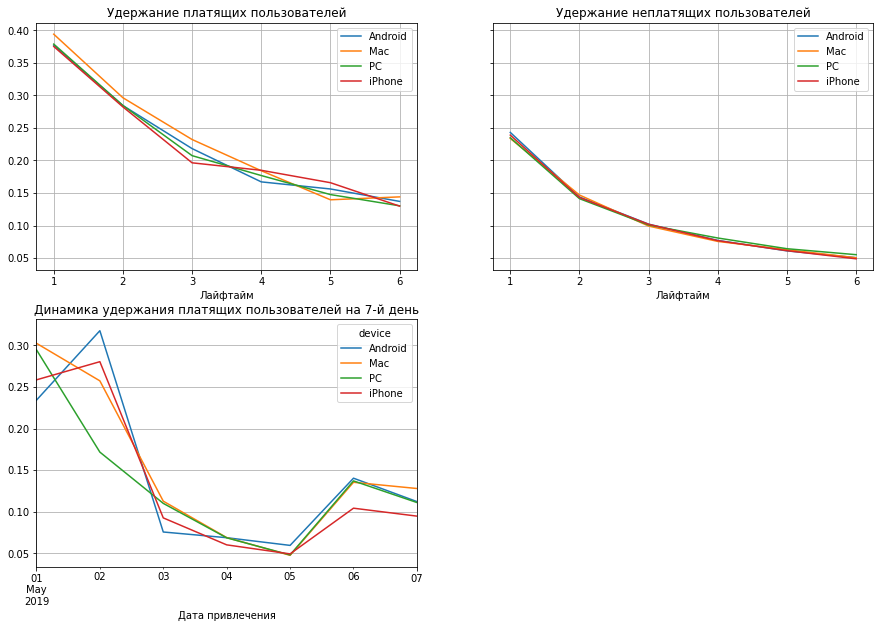

In [26]:
plot_retention(retention, retention_history, 7)

Для полной картины не хватает лишь графика истории изменений для неплатящих пользователей. Добавим его построение в `plot_retention()` и снова синхронизируем вертикальную ось с графиком для платящих пользователей.


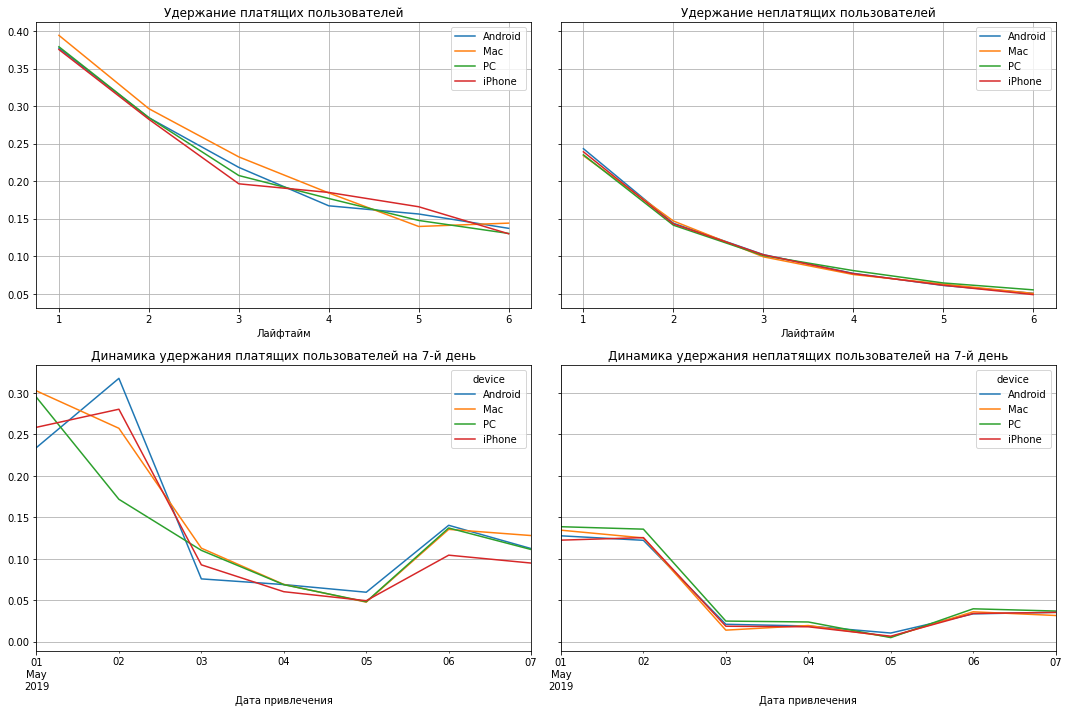

In [27]:
def plot_retention(retention, retention_history, horizon):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # исключаем наложение графиков друг на друга
    plt.tight_layout()

    plt.show()

plot_retention(retention, retention_history, 7)

Удержание неплатящих на графиках истории изменений тоже ниже, чем удержание платящих. Впрочем, как и следовало ожидать.